In [7]:
from install import *
install_requirements(chapter=2)

⏳ Installing base requirements ...
✅ Base requirements installed!
Using transformers v4.34.1
Using datasets v2.6.2
Using accelerate v0.23.0
Using sentencepiece
Using umap v0.5.6


## 1. 데이터셋

이 데이터셋은 분노, 혐오, 두려움, 기쁨, 슬픔, 놀람 여섯 개의 감정으로 구성됨.

### 1.1 허깅페이스 데이터셋 사용하기

In [8]:
from huggingface_hub import list_datasets

all_datasets = [ds.id for ds in list_datasets()]
print(f"현재 허브에는 {len(all_datasets)}개의 데이터셋이 있다.")
print(f"처음 10개 데이터셋: {all_datasets[:10]}")

현재 허브에는 205474개의 데이터셋이 있다.
처음 10개 데이터셋: ['amirveyseh/acronym_identification',
'ade-benchmark-corpus/ade_corpus_v2', 'UCLNLP/adversarial_qa',
'Yale-LILY/aeslc', 'nwu-ctext/afrikaans_ner_corpus', 'fancyzhx/ag_news',
'allenai/ai2_arc', 'google/air_dialogue', 'komari6/ajgt_twitter_ar',
'legacy-datasets/allegro_reviews']


load_dataset() 함수로 emotion 데이터셋 로드

In [9]:
from datasets import load_dataset

emotion = load_dataset("emotion", ignore_verifications=True)

  0%|          | 0/3 [00:00<?, ?it/s]

In [10]:
emotion

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 432809
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

이 객체는 파이썬 딕셔너리와 비슷하다.

In [11]:
train_ds = emotion["train"]
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness',
'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


이 경우 text열의 데이터 타입은 string이고, label열은 클래스 이름과 정수 매핑에 대한 정보가 담긴 특별한 ClassLabel 객체이다.

In [12]:
print(train_ds[:5])

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so
damned hopeful just from being around someone who cares and is awake', 'im
grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic
about the fireplace i will know that it is still on the property', 'i am feeling
grouchy'], 'label': [0, 0, 3, 2, 3]}


### 1.2 데이터셋에서 데이터프레임으로

Dataset 객체를 판다스 데이터프레임으로 변환하는 것이 편리할 때가 많다.  
이러한 변환을 위해 허깅페이스 데이터셋은 Dataset의 출력 포맷을 변경하는 `set_format()`메서드를 제공한다.

In [13]:
import pandas as pd

emotion.set_format(type="pandas")
df = emotion["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


레이블이 정수로 출력되므로 features 속성으로 label열을 선택한 후 int2str() 메서드로 레이블 이름에 해당하는 새로운 열을 데이터프레임에 추가하자.

In [14]:
def label_int2str(row):
    return emotion["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


안드레이 카패시는 좋은 모델을 훈련하려면 반드시 '데이터와 하나가 되어야'한다고 말했다.

### 1.3 클래스 분포 살펴보기

분류 문제를 다룰 때는 언제나 샘플의 클래스 분포를 조사하는 것이 좋다.

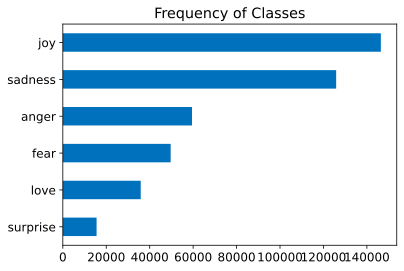

In [15]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

이 데이터셋은 불균형이 심하다. 불균형한 데이터는 다음 방법으로 다룬다.
- 소수 클래스를 랜덤하게 오버샘플링한다.
- 다수 클래스를 랜덤하게 언더샘플링한다.

### 1.4 트윗 길이 확인

트랜스포머 모델은 **최대 문맥 크기**라는 최대 입력 시퀀스 길이가 있다.  
예제에서 사용하는 DistilBERT 모델의 최대문맥크기는 512토큰이다.
트윗당 단어 분포를 보면 감정에 따른 트윗 길이가 대략 추정된다.

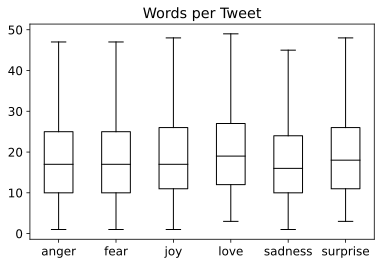

In [16]:
df["Words per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words per Tweet", by="label_name", grid=False, showfliers=False, color="black")

plt.suptitle("")
plt.xlabel("")
plt.show()

각 감정의 트윗 길이는 15개 단어 정도로 모델의 최대문맥크기보다 더 작다.  

이제 더이상 데이터프레임 포맷이 필요하지 않으니 데이터셋의 출력 포맷을 초기화하자.

In [17]:
emotion.reset_format()

## 2. 텍스트에서 토큰으로

적용할 수 있는 토큰화 전략이 몇 가지 있으며 단어를 부분단위로 나누기 위한 최적 분할은 일반적으로 말뭉치에서 학습된다.  
문자 토큰화와 단어 토큰화라는 두 가지 방식을 살펴보자.

### 2.1 문자 토큰화

가장 간단한 토큰화 방법은 각 문자를 개별로 모델에 주입하는 것.

In [18]:
text = "Tokenizing text is a core task of NLP"
tokenized_text = list(text)

print(tokenized_text)

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ',
'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o',
'f', ' ', 'N', 'L', 'P']


모델은 각 문자가 정수로 변환되리라 기대한다. 이런 과정을 `수치화`라 한다. 가장 쉬운 방법은 고유한 각 토큰을 고유한 정후로 인코딩하는 것.

In [19]:
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print(token2idx)

{' ': 0, 'L': 1, 'N': 2, 'P': 3, 'T': 4, 'a': 5, 'c': 6, 'e': 7, 'f': 8, 'g': 9,
'i': 10, 'k': 11, 'n': 12, 'o': 13, 'r': 14, 's': 15, 't': 16, 'x': 17, 'z': 18}


어휘사전에 있는 각 문자를 고유한 정수로 바꾸는 매핑 딕셔너리를 만들자. 이제 token2idx를 사용해 토큰화된 텍스트를 정수 리스트로 변환한다.

In [20]:
input_ids = [token2idx[token] for token in tokenized_text]

print(input_ids)

[4, 13, 11, 7, 12, 10, 18, 10, 12, 9, 0, 16, 7, 17, 16, 0, 10, 15, 0, 5, 0, 6,
13, 14, 7, 0, 16, 5, 15, 11, 0, 13, 8, 0, 2, 1, 3]


마지막 단계로 input_ids를 원핫벡터의 2D텐서로 바꾸자.

In [21]:
import torch
import torch.nn.functional as F

input_ids = torch.tensor(input_ids)
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2idx))

one_hot_encodings.shape

torch.Size([37, 19])

문자 수준의 토큰화는 텍스트의 구조를 무시하고 전체 문자열을 문자 스트림으로 처리한다는 것을 확인했다.  
이 방식은 철자 오류나 희귀한 단어를 처리하는 데 유용하지만, 단어 같은 언어 구조를 이 데이터에서 학습해야 한다는 큰 단점이 있다.  
이를 위해서는 상당량의 계산, 메모리, 데이터가 필요하다.  
대신, 텍스트의 일부 구조가 유지되는 토큰화를 사용한다. 

### 2.2 단어 토큰화

간단한 단어 토크나이저는 공백을 사용해 텍스트를 토큰화하는 것.

In [22]:
tokenized_text = text.split()

print(tokenized_text)

['Tokenizing', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP']


- 그 다음 문자 수준 토큰화에서 수행한 단계를 동일하게 적용해 각 단어를 하나의 ID에 매핑한다.  
- 하지만 이 방법은 구두점이 고려되지 않아 NLP. 이 하나의 토큰으로 처리된다. 이는 어휘사전의 크기 증가로 이어질 수 있다.  
- 어휘사전이 크면 신경망의 파라미터 역시 많아진다.  
- 어휘사전의 크기를 제한하는 일반적인 방법은 드물게 등장하는 단어를 무시하는 것.  
- 어휘사전에 없는 단어는 'unknown'으로 분류해 UNK 토큰으로 매핑한다. 하지만 이러면 큰 정보를 잃게 된다.  

- 이러한 것을 해결하기 위한 방법으로 `부분단어 토큰화`가 제안된다.


### 2.3 부분단어 토큰화

- 부분단어 토큰화는 기본적으로 문자 토큰화와 단어 토큰화의 장점을 결합한 방법.  
- 드물게 등장하는 단어를 더 작은 단위로 나누면 모델이 복잡한 단어나 철자 오류를 처리하기 용이함.
- 널리 사용되는 부분단어 토큰화 중 BERT와 DistilBERT의 토크나이저로 사용되는 WordPiece를 알아보자.

In [23]:
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

- AutoTokenizer클래스는 체크포인트 이름을 사용하여 모델의 설정, 사전 훈련된 가중치, 어휘 사전을 자동으로 추출하는 자동 클래스

In [24]:
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953,
2361, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [25]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl',
'##p', '[SEP]']


세가지 부분을 알아보자.
- [CLS], [SEP]가 시퀀스 처음과 끝에 추가됐다. 이는 시작과 끝을 알리는 토큰이다.
- 토큰이 모두 소문자로 변환됐다. 이것이 이 체크포인트의 특징.
- tokenizing과 NLP가 각각 두개의 토큰으로 나뉘었다. 자주 등장하는 토큰이 아니기 때문이다. #는 앞의 문자열이 공백이 아님을 뜻한다. 이런 접두사가 붙은 토큰은 문자열로 다시 바꿀 때 앞의 토큰과 합친다.

In [26]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp [SEP]


- AutoTokenizer 클래스는 토크나이저에 관한 정보를 제공하는 속성도 몇 가지 있다.

In [27]:
tokenizer.vocab_size

30522

In [28]:
tokenizer.model_max_length

512

In [29]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

- 사전훈련된 모델을 사용할 때, 모델 훈련에 사용한 것과 동일한 토크나이저를 사용하는 것이 정말 중요하다.
- 모델 입장에서 토크나이저를 바꾸는 것은 어휘사전을 뒤섞는 것이나 다름없다.

### 2.4 전체 데이터셋 토큰화하기

- 전체 말뭉치를 토큰화하기 위해 DatasetDict 객체의 map() 메서드를 사용한다.
- 먼저, 샘플을 토큰화할 처리함수가 필요하다.

In [30]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

- 이 함수는 토크나이저를 샘플 배치에 적용한다.
- padding=True로 지정하면 배치에 있는 가장 긴 샘플 크기에 맞춰 샘플을 0으로 패딩함.
- truncation=True로 설정하면 모델의 최대 문맥 크기에 맞춰 샘플을 잘라낸다.

In [31]:
print(tokenize(emotion["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0,
0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000,
2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300,
102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
1, 1]]}


- 패딩결과를 보면 input_ids의 첫번째 원소가 두번째보다 짧으므로 길이를 동일하게 맞추기 위해 끝에 0을 추가했다. 0은 어휘사전에 있는 [PAD]토큰에 해당한다.
- 토크나이저는 인코딩된 트윗을 input_ids로 반환하고, attention_mask 배열 리스트도 반환한다. 추가된 패딩 토큰때문에 모델이 혼동하지 않게 하려는 조치다.

처리 함수를 정의하면 코드 한 줄로 말뭉치에 있는 모든 분할에 이 과정을 적용할 수 있다.

In [32]:
emotions_encoded = emotion.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

- 기본적으로 map() 메서드는 말뭉치에 있는 모든 샘플에 개별적으로 작용하므로, batched=True로 설정하여 트윗을 배치로 인코딩한다.
- batch_size=None으로 설정했기 때문에 전체 데이터셋이 하나의 배치로 tokenize()함수에 적용된다. 이렇게 하면 입력 텐서와 어텐션 마스크는 전역적으로 동일한 크기로 생성된다.

## 3. 텍스트 분류 모델 훈련하기

- BERT같은 모델은 텍스트 시퀀스에 있는 마스킹된 단어를 예측하도록 사전 훈련된다.
- 하지만 이런 언어 모델을 바로 텍스트 분류에 사용하지는 못한다. 약간의 수정이 필요하다. 어떤 수정이 필요한지 알기 위해 인코더 기반 모델의 구조를 살펴보자.

- 인코더기반 모델은 먼저 텍스트를 토큰화해 토큰 인코딩이라 부르는 ont-hot 벡터로 나타낸다.
- 그다음 토킨 인코딩을 저차원 공간의 벡터인 토큰 임베딩으로 변환한다.
- 그다음 토큰 임베딩을 인코더 블록층에 통과시켜 각 입력 토큰에 대한 은닉상태를 만든다. 각 은닉상태는 언어 모델링의 사전 훈련 목표를 달성하기 위해 마스킹된 입력 토큰을 예측하는 층으로 전달된다.
- 그리고 분류 작업에서는 이 언어 모델링층을 분류층으로 바꾼다.

트위터 데이터셋에서 이런 모델을 훈련하는 방법은 두가지이다.  
**특성 추출**
- 사전 훈련된 모델을 수정하지 않고 은닉 상태를 feature로 사용해 분류 모델을 훈련.  

**fine tuning**
- 사전 훈련된 모델의 파라미터도 업데이트하기 위해 전체 모델을 end-to-end로 훈련.

### 3.1 트랜스포머를 특성 추출기로 사용하기

- 트랜스포머는 특성 추출기로 사용하기 편하다.
- 훈련하는 동안 바디의 가중치를 동결하고 은닉 상태를 분류 모델의 특성으로 사용한다. 이 방식은 얕은 모델을 빠르게 훈련한다는 장점이 있다.
- 이때 훈련되는 모델로는 신경망 분류 층이거나 랜덤포레스트같이 그레디언트에 의존하지 않는 기법 등이 있다.

#### 사전 훈련된 모델 사용하기

- 트랜스포머스의 또 다른 자동 클래스인 AutoModel을 사용해보자.
- AutoTokenizer와 비슷하게 AutoModel클래스는 사전 훈련된 가중치를 로드하는 from_pretrained() 메서드가 있다.

In [33]:
torch.__version__

'2.1.0a0+b5021ba'

In [34]:
from transformers import AutoModel

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

In [36]:
model

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Li